#**Load GCP**

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fuzzywuzzy
!pip install dash
!pip install plotly
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


# **ELTs**

##**INVDB**

In [50]:
directory = '/content/drive/MyDrive/Software_Tools/ReAllocate_Guest_Tool/src/HTR_INV_DB'
merged_df = pd.DataFrame()
wm_inventory_view = pd.read_csv('/content/drive/MyDrive/Software_Tools/Dev_Ops/src/views/2023_wm_inventory_reservation_details.csv',encoding='ISO-8859-1')
for i in range(1,8):
    temp_df = pd.read_csv(directory + '/' + '2023_wm_inventory_reservation_details_'+str(i)+'.csv',encoding='ISO-8859-1')
    merged_df = pd.concat([merged_df, temp_df], ignore_index=True)


merged_df.drop_duplicates(subset=['confirmation'],inplace=True)

In [51]:
merged_df = pd.concat([merged_df, wm_inventory_view], ignore_index=True)

In [52]:
merged_df.drop_duplicates(subset=['confirmation'],inplace=True)

##**CDS**

In [53]:
airbnb_beds_24_historical_data = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Airbnb and Beds24 Combined Clean Data(Final Data).csv',encoding='ISO-8859-1')
wm_inventory_ds = pd.read_csv('/content/drive/MyDrive/Software_Tools/ReAllocate_Guest_Tool/src/2024_nov_wm_inventory_reservations_details(wm).csv',encoding='ISO-8859-1')
airbnb_full_historical_data = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/airbnb_01_2008-11_2024.csv',encoding='ISO-8859-1')
reservation_tracking_completed = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Confirmed Bookings Guest Reservation Tracking(completed).csv',encoding='ISO-8859-1')
reservation_tracking_cancelled = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Confirmed Bookings Guest Reservation Tracking(Cancelled ).csv',encoding='ISO-8859-1')
reservation_tracking_upcoming = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Confirmed Bookings Guest Reservation Tracking(upcoming bookings).csv',encoding='ISO-8859-1')

In [54]:
manual_record = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Booking and Cancellation Manual Record.csv',encoding='ISO-8859-1')

In [55]:
airbnb_full_historical_data.dropna(subset=['Confirmation code','Gross earnings','Confirmation code'], inplace= True)

In [56]:
airbnb_full_historical_data = airbnb_full_historical_data[~airbnb_full_historical_data['Confirmation code'].isin(airbnb_beds_24_historical_data['Confirmation code'].unique().tolist())]
airbnb_full_historical_data = airbnb_full_historical_data[airbnb_full_historical_data.Listing.isin(airbnb_beds_24_historical_data.Listing.unique().tolist())]

In [57]:
airbnb_beds_24_historical_data['Location'] = airbnb_beds_24_historical_data['Location'].str.replace('WorldMark', '').str.strip()
wm_inventory_ds['resort'] = wm_inventory_ds['resort'].str.replace('WorldMark', '').str.strip()
wm_inventory_view.rename(columns={' ':'resort'},inplace = True)
wm_inventory_view['resort'] = wm_inventory_view['resort'].str.replace('WorldMark', '').str.strip()

In [58]:
merged_df['resort'] = merged_df['resort'].str.replace('WorldMark', '').str.strip()
merged_df.rename(columns={' ':'resort'},inplace = True)
merged_df['resort'] = merged_df['resort'].str.replace('WorldMark', '').str.strip()

In [59]:
#wm_inventory_ds['confirmation'] = wm_inventory_ds[' confirmation '].str.strip()
#wm_inventory_ds.drop(columns=[' confirmation '],inplace = True)

In [60]:
#compatible_locations = [x for x in airbnb_beds_24_historical_data.Location.unique() if x in wm_inventory_ds.resort.unique()]

In [61]:
from fuzzywuzzy import fuzz
import re

beds_24_location_list = [str(loc).replace("WorldMark", "").strip() for loc in airbnb_beds_24_historical_data.Location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in merged_df.resort.unique() if str(loc) != 'nan']

matches = {}

for loc1 in beds_24_location_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")



def map_location_to_resort(df1,mapping_dict,location_tag):
    """
    Transforms the 'Location' column of df1 to match 'resort' column values in df2.

    Parameters:
    df1 (pd.DataFrame): The first dataset with a 'Location' column.
    df2 (pd.DataFrame): The second dataset with a 'resort' column.
    mapping_dict (dict): A dictionary mapping df1 'Location' values to df2 'resort' values.

    Returns:
    pd.DataFrame: Transformed df1 with updated 'Location' values.
    """

    df1_transformed = df1.copy()


    df1_transformed[location_tag] = df1_transformed[location_tag].map(lambda loc: mapping_dict.get(loc, [loc])[0])

    return df1_transformed


def infer_unit_type(unit_description):
    # Search for a number followed by "Bedroom" in the unit description
    match = re.search(r'(\d+)\s*Bedroom', unit_description, re.IGNORECASE)
    if match:
        return float(match.group(1))
    elif 'studio' in unit_description.lower():
        return 1.0
    else:
        return np.nan

Kihei Maui -> ['Kihei']
Parkcity -> ['Park City']
Kona -> ['Kona']
Kihei -> ['Kihei']
Palm Springs -> ['Palm Springs']
Club Wyndham Park City -> ['Park City']
South Shore -> ['South Shore']
Leavenworth -> ['Leavenworth']
Inn at the Park -> ['Estes Park']
Kona Hawaiian -> ['Kona']
Royal Sea Cliff Kona -> ['Kona']
Estes Park -> ['Estes Park']
Yellowstone -> ['West Yellowstone']
California Windsor -> ['Windsor']
Solvang -> ['Solvang']
Indio Resort -> ['Indio']
Steamboat Springs -> ['Steamboat Springs']
Lake Tahoe -> ['Lake Tahoe']
Marina Dunes -> ['Marina Dunes']
Hawaii Kihei -> ['Kihei']
Windsor -> ['Windsor']
Plaza Resort and Spa -> ['Plaza Resort and Spa']


In [62]:
beds_24_historical_mapped = map_location_to_resort(airbnb_beds_24_historical_data,matches,'Location')


In [63]:
beds_24_historical_mapped.columns

Index(['Confirmation code', 'Status', 'Guest name', 'Contact', '# of adults',
       '# of children', '# of infants', 'Start date', 'End date',
       '# of nights', 'Booked', 'Listing', 'Earnings', 'Location',
       'Unit Type'],
      dtype='object')

In [64]:
batch_set = merged_df[['confirmation',
                             'reservationId',
                             'account',
                             'resort',
                             'checkin',
                             'checkout',
                             'cancel_by',
                             'Unit',
                             'credits',
                             'rented?',
                             'listing?',
                             'cost basis',
                             'target payout',
                             'nights',
                             'booking_date']]
batch_set.dropna(subset=['Unit'],inplace=True)
batch_set['Unit Type'] = batch_set['Unit'].apply(infer_unit_type)
beds_24_historical_mapped.rename(columns={'Confirmation code':'Confirmed Reservation'},inplace=True)
training_set = beds_24_historical_mapped[['Confirmed Reservation',
                                               #'Status',
                                               #'Guest name',
                                               #'Contact',
                                               #'# of adults',
                                               #'# of children',
                                               #'# of infants',
                                               'Start date',
                                               'End date',
                                               '# of nights',
                                               'Booked',
                                               'Listing',
                                               'Earnings',
                                               'Location',
                                               'Unit Type']]

<ipython-input-64-a4d61c61ea8d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_set.dropna(subset=['Unit'],inplace=True)
<ipython-input-64-a4d61c61ea8d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_set['Unit Type'] = batch_set['Unit'].apply(infer_unit_type)


In [65]:
training_set['Start date'] = pd.to_datetime(training_set['Start date'], format='%d-%b-%y').dt.date
training_set['End date'] = pd.to_datetime(training_set['End date'], format='%d-%b-%y').dt.date

#training_set = training_set[training_set['Start date'].apply(lambda x: x if isinstance(x, pd.Timestamp) else pd.Timestamp(x)).dt.date >= pd.to_datetime('2025-01-04').date()]
#training_set = training_set[training_set['Start date'].apply(lambda x: x if isinstance(x, pd.Timestamp) else pd.Timestamp(x)).dt.date <= pd.to_datetime('2025-01-31').date()]

<ipython-input-65-c2fd48bd085d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['Start date'] = pd.to_datetime(training_set['Start date'], format='%d-%b-%y').dt.date
<ipython-input-65-c2fd48bd085d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['End date'] = pd.to_datetime(training_set['End date'], format='%d-%b-%y').dt.date


In [66]:
historical_set = training_set

In [100]:
historical_set[(historical_set.Location == 'Park City') &
 (historical_set['Unit Type'] == 3.0) & (historical_set['Start date'] >= pd.to_datetime('2024-03-01').date()) & (historical_set['Start date'] <= pd.to_datetime('2024-03-28').date())]

,Confirmed Reservation,Start date,End date,# of nights,Booked,Listing,Earnings,Location,Unit Type
1274,HMWZTPN2EM,2024-03-01,2024-03-06,5.0,2/7/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",3115.05,Park City,3.0
1275,HMASWS848S,2024-03-01,2024-03-04,3.0,2/7/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",0.00,Park City,3.0
1276,HMXYPQXT94,2024-03-01,2024-03-04,3.0,2/29/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot tub, Firep...",2037.00,Park City,3.0
1283,HMK5EC2F55,2024-03-04,2024-03-08,4.0,2/16/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",1894.41,Park City,3.0
1284,HMTXJHNWEJ,2024-03-04,2024-03-08,4.0,12/8/2023,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",3437.06,Park City,3.0
1288,HMYQEE9YZE,2024-03-08,2024-03-13,5.0,2/26/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",4210.77,Park City,3.0
1289,HM8DKHWKP2,2024-03-08,2024-03-13,5.0,2/10/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",3789.69,Park City,3.0
1290,HMPFKE98HC,2024-03-08,2024-03-13,5.0,2/3/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",5007.14,Park City,3.0
1293,HMY398Y9MW,2024-03-09,2024-03-16,7.0,1/25/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",5474.58,Park City,3.0
1294,HMKF9E3WQF,2024-03-09,2024-03-16,7.0,1/14/2024,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",6551.38,Park City,3.0


In [68]:
airbnb_patch_data = airbnb_full_historical_data.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
airbnb_patch_data.rename(columns={'Confirmation code': 'Confirmed Reservation'},inplace=True)
airbnb_patch_data.drop_duplicates(subset=['Confirmed Reservation'], inplace=True)

airbnb_patch_data = airbnb_patch_data[['Confirmed Reservation',
                                       'Location',
                                       'Unit Type',
                                       'Start date',
                                       'End date',
                                       'Booking date',
                                       'Gross earnings',
                                       'Nights',
                                       'Listing']].rename(columns={'Gross earnings': 'Earnings', 'Nights': '# of nights', 'Booking date': 'Booked'})

training_set = pd.concat([training_set, airbnb_patch_data], ignore_index=True)

In [69]:
training_set.dropna(inplace=True)

In [70]:
reservation_tracking_completed = reservation_tracking_completed[~reservation_tracking_completed['Confirmed Reservation'].isin(training_set['Confirmed Reservation'].unique())]
reservation_tracking_completed['location'] = reservation_tracking_completed['location'].str.replace('WorldMark', '').str.strip()
reservation_tracking_completed = reservation_tracking_completed[reservation_tracking_completed.Listing.isin(training_set.Listing.unique())]
matches = {}
reservation_tracking_completed_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in reservation_tracking_completed.location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in reservation_tracking_completed_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

el -> ['West Yellowstone']
kona -> ['Kona']
tahoe -> ['Lake Tahoe']
pr -> ['Steamboat Springs', 'Palm Springs']
indio -> ['Indio']
Kihei -> ['Kihei']
marina dunes -> ['Marina Dunes']
Leavenworth -> ['Leavenworth']
yellowstone -> ['West Yellowstone']
estes park -> ['Estes Park']
south shore -> ['South Shore']
lake tahoe -> ['Lake Tahoe']
Estes Park -> ['Estes Park']
Lake Tahoe -> ['Lake Tahoe']
South Shore -> ['South Shore']
Hawaii Kihei -> ['Kihei']
Yellowstone -> ['West Yellowstone']
West Yellowstone -> ['West Yellowstone']
Marina Dunes -> ['Marina Dunes']
Indio Resort -> ['Indio']
Palm Springs -> ['Palm Springs']
Kona -> ['Kona']
Solvang -> ['Solvang']
marina Dunes -> ['Marina Dunes']
Wyndham Kona -> ['Kona']
Lake Tahoe (OLD) -> ['Lake Tahoe']
Steamboat -> ['Steamboat Springs']
Park City WM -> ['Park City']
Lake tahoe -> ['Lake Tahoe']
Park City -> ['Park City']
Plaza Resort and Spa -> ['Plaza Resort and Spa']
Tahoe I -> ['Lake Tahoe']
Lake Tahoe II -> ['Lake Tahoe']
Lake Tahoe I -> 

In [71]:
#reservation_tracking_completed.rename(columns={'Confirmation code':'Confirmed Reservation'},inplace=True)

In [72]:
def calculate_nights(dataset):
    """
    Adds a 'Nights' column to the dataset, calculating the number of nights between the 'Check-in' and 'Check-out' dates,
    while handling mixed or invalid date formats.

    Parameters:
    dataset (pd.DataFrame): A pandas DataFrame with 'Check-in' and 'Check-out' columns.

    Returns:
    pd.DataFrame: The original dataset with an additional 'Nights' column.
    """
    # Handle mixed date formats and invalid dates
    dataset['Check-in'] = pd.to_datetime(
        dataset['Check-in'], errors='coerce', format='%d-%b-%y', dayfirst=True
    )
    dataset['Check-out'] = pd.to_datetime(
        dataset['Check-out'], errors='coerce', format='%d-%b-%y', dayfirst=True
    )

    # Check for invalid dates (set to NaT) and handle them
    if dataset['Check-in'].isna().any() or dataset['Check-out'].isna().any():
        print("Warning: Some dates could not be parsed and were set to NaT.")

    # Calculate nights, avoiding errors with invalid dates
    dataset['Nights'] = (dataset['Check-out'] - dataset['Check-in']).dt.days

    # Optionally, replace NaN values in 'Nights' with a default or flag
    dataset['Nights'] = dataset['Nights'].fillna(-1)  # Use -1 to flag invalid date ranges

    return dataset



reservation_tracking_completed = calculate_nights(reservation_tracking_completed)

In [73]:
reservation_tracking_completed_mapped = map_location_to_resort(reservation_tracking_completed,matches,'location')
reservation_tracking_completed_patch = reservation_tracking_completed_mapped.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
reservation_tracking_completed_patch.drop_duplicates(subset=['Confirmed Reservation'], inplace=True)

reservation_tracking_completed_patch = reservation_tracking_completed_patch[['Confirmed Reservation',
                                       'Location',
                                       'Unit Type',
                                       'Check-in',
                                       'Check-out',
                                       'Booked on',
                                       'Total Payout ',
                                       'Nights',
                                       'Listing']].rename(columns={'Total Payout ': 'Earnings', 'Nights': '# of nights', 'Booked on': 'Booked', 'Check-in':'Start date', 'Check-out':'End date'})
reservation_tracking_completed_patch.reset_index(drop=True, inplace=True)
training_set = pd.concat([training_set, reservation_tracking_completed_patch], ignore_index=True)

In [74]:
len(training_set)

2564

In [75]:
training_set

,Confirmed Reservation,Start date,End date,# of nights,Booked,Listing,Earnings,Location,Unit Type
0,HM59YBAWK5,2022-12-30,2023-01-05,6.0,12/13/2022,"1 Bedroom Apt near Beach, Pool, Hot Tub, BBQ",2454.10,Kihei,1.0
1,HMHR8QD8FA,2022-12-23,2022-12-29,6.0,11/15/2022,"1 Bedroom Apt near Beach, Pool, Hot Tub, BBQ",2631.61,Kihei,1.0
2,HMAWCC3HNF,2020-12-20,2021-01-03,14.0,10/12/2020,2048 sqft @ Frostwood Gondola w/ Pool & Movie ...,6290.10,Park City,4.0
3,HMCEMN4X3F,2023-01-03,2023-01-06,3.0,1/3/2023,"1 BR ½ mile from Downtown, Pool, Hot Tub, BBQ",718.95,Kona,1.0
4,HM29QPTFK9,2022-12-28,2022-12-29,1.0,12/16/2022,"1 BR ½ mile from Downtown, Pool, Hot Tub, BBQ",484.03,Kona,1.0
...,...,...,...,...,...,...,...,...,...
2559,RWO0037057912BR,2025-01-17 00:00:00,2025-01-20 00:00:00,3.0,15-Oct-24,"3BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",2181.78,Park City,3.0
2560,RWO0042095439BR,2025-01-18 00:00:00,2025-01-25 00:00:00,7.0,18-Dec-24,"4BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",6001.00,Park City,4.0
2561,RWO0041584439BR,2025-01-22 00:00:00,2025-01-26 00:00:00,4.0,3-Jan-24,"4BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",4020.43,Park City,4.0
2562,RWO0041857397BR,2025-01-20 00:00:00,2025-01-27 00:00:00,7.0,18-Nov-24,"4BR Ski-in/out+Ski Valet, Pool, Hot Tub, Firep...",8272.58,Park City,4.0


In [76]:
reservation_tracking_cancelled.rename(columns={reservation_tracking_cancelled.columns[0]: 'Location'}, inplace=True)

In [77]:
#reservation_tracking_cancelled.rename(columns={'Confirmation code':'Confirmed Reservation'},inplace=True)

In [78]:
reservation_tracking_cancelled.columns

Index(['Location', 'Airbnb a/c ', 'Photo ID Name', 'Guests', 'Check-in',
       'Check-out', 'Booked on', 'Listing', 'Confirmation code',
       'Total Payout ', 'Confirmed Reservation', 'account', 'Owner',
       'Cancellation policy', 'Res \nCheck-In ', 'Res \nCheck-Out ',
       'Photo id msg status', 'Check-in/check-out expectations', 'Attractions',
       'wifi', 'Check in instructions', 'Check in photos ',
       'WM-GC \nadded Date', 'GC Status', 'Text Message', 'Assign',
       'Communcation Link', 'Notes', 'Google voice', 'good behavior?',
       'good listing switch', 'bad listing switch',
       'Key Resort Contact/Staff to contratulate or mention on the Resort Survey',
       'Resort Survey done?', 'Link to Survey done', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37'],
      dtype='object')

In [79]:
reservation_tracking_cancelled = reservation_tracking_cancelled[~reservation_tracking_cancelled['Confirmed Reservation'].isin(training_set['Confirmed Reservation'].unique())]
reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('WorldMark', '').str.strip()
reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('pc', 'Park City').str.strip()
reservation_tracking_cancelled = reservation_tracking_cancelled[reservation_tracking_cancelled.Listing.isin(training_set.Listing.unique())]
matches = {}
reservation_tracking_cancelled_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in reservation_tracking_cancelled.Location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in reservation_tracking_cancelled_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

Park City -> ['Park City']
Estes Park -> ['Estes Park']
Kihei -> ['Kihei']
Hawaii Kihei -> ['Kihei']
Lake tahoe -> ['Lake Tahoe']
kihei -> ['Kihei']
Lake Tahoe (OLD) -> ['Lake Tahoe']
South Shore -> ['South Shore']
Kona -> ['Kona']
Steamboat -> ['Steamboat Springs']
Park City WM -> ['Park City']
Lake Tahoe -> ['Lake Tahoe']
Solvang -> ['Solvang']
Yellowstone -> ['West Yellowstone']
Marina Dunes -> ['Marina Dunes']
Lake Tahoe III -> ['Lake Tahoe']


<ipython-input-79-fac9ff9ab909>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('WorldMark', '').str.strip()
<ipython-input-79-fac9ff9ab909>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('pc', 'Park City').str.strip()


In [80]:
reservation_tracking_cancelled_mapped = map_location_to_resort(reservation_tracking_cancelled,matches,'Location')
reservation_tracking_cancelled_mapped = calculate_nights(reservation_tracking_cancelled)
reservation_tracking_cancelled_patch = reservation_tracking_cancelled_mapped.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
reservation_tracking_cancelled_patch.drop_duplicates(subset=['Confirmed Reservation'], inplace=True)

reservation_tracking_cancelled_patch = reservation_tracking_cancelled_patch[['Confirmed Reservation',
                                       'Location_x',
                                       'Unit Type',
                                       'Check-in',
                                       'Check-out',
                                       'Booked on',
                                       'Total Payout ',
                                       'Nights',
                                       'Listing']].rename(columns={'Location_x':'Location','Total Payout ': 'Earnings', 'Nights': '# of nights', 'Booked on': 'Booked', 'Check-in':'Start date', 'Check-out':'End date'})

training_set = pd.concat([training_set, reservation_tracking_cancelled_patch], ignore_index=True)

In [81]:
training_set.dropna(inplace=True)
len(training_set)

2583

In [82]:
reservation_tracking_upcoming = reservation_tracking_upcoming[~reservation_tracking_upcoming['Confirmed Reservation'].isin(training_set['Confirmed Reservation'].unique())]
reservation_tracking_upcoming['Location'] = reservation_tracking_upcoming['Location'].str.replace('WorldMark', '').str.strip()
reservation_tracking_upcoming['Location'] = reservation_tracking_upcoming['Location'].str.replace('pc', 'Park City').str.strip()
reservation_tracking_upcoming = reservation_tracking_upcoming[reservation_tracking_upcoming.Listing.isin(training_set.Listing.unique())]

matches = {}
reservation_tracking_upcoming_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in reservation_tracking_upcoming.Location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in reservation_tracking_upcoming_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

Kihei -> ['Kihei']
Lake  Tahoe III -> ['Lake Tahoe']
Steamboat -> ['Steamboat Springs']
Park City -> ['Park City']
Solvang -> ['Solvang']
Marina Dunes -> ['Marina Dunes']
Plaza Resort and Spa -> ['Plaza Resort and Spa']


<ipython-input-82-50c42079283f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservation_tracking_upcoming['Location'] = reservation_tracking_upcoming['Location'].str.replace('WorldMark', '').str.strip()
<ipython-input-82-50c42079283f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservation_tracking_upcoming['Location'] = reservation_tracking_upcoming['Location'].str.replace('pc', 'Park City').str.strip()


In [83]:
reservation_tracking_upcoming_mapped = map_location_to_resort(reservation_tracking_upcoming,matches,'Location')
reservation_tracking_upcoming_mapped = calculate_nights(reservation_tracking_cancelled)
reservation_tracking_upcoming_patch = reservation_tracking_upcoming_mapped.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
reservation_tracking_upcoming_patch.drop_duplicates(subset=['Confirmed Reservation'], inplace=True)

reservation_tracking_upcoming_patch = reservation_tracking_upcoming_patch[['Confirmed Reservation',
                                       'Location_x',
                                       'Unit Type',
                                       'Check-in',
                                       'Check-out',
                                       'Booked on',
                                       'Total Payout ',
                                       'Nights',
                                       'Listing']].rename(columns={'Location_x':'Location','Total Payout ': 'Earnings', 'Nights': '# of nights', 'Booked on': 'Booked', 'Check-in':'Start date', 'Check-out':'End date'})

training_set = pd.concat([training_set, reservation_tracking_upcoming_patch], ignore_index=True)

In [84]:
training_set.dropna(inplace=True)
len(training_set)

2612

In [85]:
# Remove special characters
manual_record['min target'] = manual_record['min target'].replace(
    {'\$': '', ',': ''}, regex=True
)

# Convert to float and coerce errors
manual_record['min target'] = pd.to_numeric(manual_record['min target'], errors='coerce')

# Filter rows where 'min target' is greater than 10.0
manual_record = manual_record[~(manual_record['min target'] < 10.0)]

In [86]:
manual_record.columns

Index(['Unnamed: 0', 'confirmation', 'account', 'resort', 'checkin',
       'checkout', 'cancel_by', 'unit', 'credits', 'rented?', 'cancel_or_hold',
       'notes', 'listing?', 'cost basis', 'min target', 'With 3% for airbnb',
       'Per night rate', 'name', 'amount', 'card paid with', 'card1',
       'charged1', 'card2', 'charged2', 'charged3', 'card3', 'charged4',
       'card4', 'charged5', 'card5', 'nights', 'tracked_from', 'booking_date',
       'guest_certificate', 'ghost_reservations', 'housekeeping used?',
       'canceled_date', 'reservationId', 'canceled_date.1', 'HKT cash amount',
       'HKT'],
      dtype='object')

In [87]:
manual_record.dropna(subset=['min target'],inplace=True)
manual_record = manual_record[~manual_record.confirmation.isin(training_set['Confirmed Reservation'].unique())]
manual_record['resort'] = manual_record['resort'].str.replace('WorldMark', '').str.strip()
#manual_record['resort'] = manual_record['resort'].str.replace('pc', 'Park City').str.strip()
#manual_record = manual_record[manual_record.Listing.isin(training_set.Listing.unique())]

matches = {}
manual_record_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in manual_record.resort.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in manual_record_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

Park City -> ['Park City']
Kona -> ['Kona']
Lake Tahoe -> ['Lake Tahoe']
Steamboat Springs -> ['Steamboat Springs']
Solvang -> ['Solvang']
Leavenworth -> ['Leavenworth']
Kihei -> ['Kihei']
West Yellowstone -> ['West Yellowstone']
Estes Park -> ['Estes Park']
South Shore -> ['South Shore']
UT-Park City -> ['Park City']
Palm Springs -> ['Palm Springs']
HI-Kihei, Maui -> ['Kihei']
NV-South Shore -> ['South Shore']


<ipython-input-87-db1220fb2ea4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_record.dropna(subset=['min target'],inplace=True)


In [88]:
manual_record_mapped = map_location_to_resort(manual_record,matches,'resort').rename(columns={'checkin':'Check-in','checkout': 'Check-out'})
manual_record_mapped = calculate_nights(manual_record_mapped)
manual_record_mapped['unit'] = manual_record_mapped['unit'].apply(infer_unit_type)
manual_record_mapped['cost basis'] = (
    manual_record_mapped['cost basis']
    .replace('[\$,]', '', regex=True)   # Remove currency symbols and commas
    .replace(r'[^\d.]', np.nan, regex=True)  # Replace non-numeric strings with NaN
    .astype(float)  # Convert to float
)
manual_record_mapped['cost basis'] = pd.to_numeric(manual_record_mapped['cost basis'], errors='coerce')
manual_record_mapped['min target'] = pd.to_numeric(manual_record_mapped['min target'], errors='coerce')
manual_record_mapped['Price'] = manual_record_mapped['cost basis'] * manual_record_mapped['min target']
manual_record_mapped = manual_record_mapped[['confirmation',
                                       'resort',
                                       'unit',
                                       'Check-in',
                                       'Check-out',
                                       'booking_date',
                                       'Price',
                                       'Nights',
                                       'listing?']].rename(columns={'resort':'Location',
                                                                    'Price': 'Earnings',
                                                                    'Nights': '# of nights',
                                                                    'booking_date': 'Booked',
                                                                    'Check-in':'Start date',
                                                                    'Check-out':'End date',
                                                                    'listing?':'Listing',
                                                                    'confirmation': 'Confirmed Reservation',
                                                                    'unit':'Unit Type'})

training_set = pd.concat([training_set, manual_record_mapped], ignore_index=True)

In [89]:
len(training_set)

3084

In [90]:
training_set.dropna(inplace=True)

In [91]:
#traning_set = training_set[pd.notnull(training_set.Earnings)]

In [92]:
#training_set['Earnings'] = (
#    training_set['Earnings']
#    .replace({'\$': '', ',': '', r'\((.*?)\)': r'-\1'}, regex=True)
#    .astype(float)
#)

In [93]:
#training_set = training_set[training_set.Earnings <= 40000]
#training_set = training_set[training_set.Earnings >= 400]

In [94]:
len(training_set)

2867

In [95]:
training_set['Unit Type'].unique()

array([ 1.,  4.,  2.,  3., 10.])

In [96]:
training_set[(training_set.Location == 'Leavenworth') &
 (training_set['Unit Type'] == 2.0) ]

,Confirmed Reservation,Start date,End date,# of nights,Booked,Listing,Earnings,Location,Unit Type
101,HM33XBBTMX,2024-08-17,2024-08-18,1.0,2/13/2024,"2BR Bavarian Charm in Cascades Retreat!\"",$0""",0.00,Leavenworth,2.0
102,HMYTJX33TB,2023-10-14,2023-10-15,1.0,9/25/2023,"2BR Bavarian Charm in Cascades Retreat!\"",$0""",0.00,Leavenworth,2.0
103,HMQNEYRHHT,2023-10-14,2023-10-15,1.0,9/25/2023,"2BR Bavarian Charm in Cascades Retreat!\"",$0""",0.00,Leavenworth,2.0
104,HMWYB4DWBM,2023-09-22,2023-09-24,2.0,9/5/2023,"2BR Bavarian Charm in Cascades Retreat!\"",$0""",0.00,Leavenworth,2.0
105,HMFEJTKKBC,2023-12-28,2023-12-30,2.0,11/28/2023,"2BR Bavarian Charm in Cascades Retreat!\"",$1",108.71,Leavenworth,2.0
...,...,...,...,...,...,...,...,...,...
428,HM2SKC2F52,2024-01-01,2024-01-02,1.0,12/16/2023,2BR: Bavarian Charm in Cascades Retreat!,14.55,Leavenworth,2.0
429,HMSWRSRCDK,2023-09-02,2023-09-04,2.0,8/30/2023,2BR: Bavarian Charm in Cascades Retreat!,840.99,Leavenworth,2.0
1747,HMRRMRZMWK,2023-12-01,2023-12-02,1.0,30-Oct-23,2BR Bavarian Charm in Cascades Retreat,401.40,Leavenworth,2.0
1758,HMDZKAY5ZH,2023-12-16,2023-12-17,1.0,19-Nov-23,2BR Bavarian Charm in Cascades Retreat,516.60,Leavenworth,2.0


#**Analysis**

In [97]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def get_us_holidays(year):
    return {
        "New Year's Day": datetime(year, 1, 1),
        "Independence Day": datetime(year, 7, 4),
        "Thanksgiving": datetime(year, 11, 28),
        "Christmas": datetime(year, 12, 25),
        "Labor Day": datetime(year, 9, 2),
        "Memorial Day": datetime(year, 5, 27),
        "Veterans Day": datetime(year, 11, 11),
        "Martin Luther King Jr. Day": datetime(year, 1, 15),
        "Columbus Day": datetime(year, 10, 12),
        "Washingtons Birthday": datetime(year, 2, 18),
        "Presidents Day": datetime(year, 2, 19) ,
        "Cochela_Festival_w_1":datetime(year, 4, 12),
        "Cochela_Festival_w_2":datetime(year, 4, 19),
        "Cochela_Festival_w_3":datetime(year, 4, 26),
        "Oktober_Festival_w_1": datetime(year, 10, 11),
        "Oktober_Festival_w_2":datetime(year, 4,18),
        "Oktober_Festival_w_3":datetime(year, 4, 25)

    }


def is_holiday_overlap(checkin, checkout):
    if pd.isnull(checkin) or pd.isnull(checkout):
        return 0
    holidays = get_us_holidays(checkin.year)
    for holiday in holidays.values():
        if checkin <= holiday <= checkout:
            return 1
    return 0




batch_set['checkin'] = pd.to_datetime(batch_set['checkin'], format='%d-%b-%y')
batch_set['checkout'] = pd.to_datetime(batch_set['checkout'], format='%d-%b-%y')
batch_set['booking_date'] = pd.to_datetime(batch_set['booking_date'], format='%d-%b-%y', errors='coerce')
batch_set['booking_date'] = batch_set['booking_date'].fillna(
    pd.to_datetime(batch_set['booking_date'], format='%y-%b-%d', errors='coerce')
)
def parse_dates(date_str):
    for fmt in ('%d-%b-%y', '%m/%d/%Y', '%d/%m/%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if no format matches

training_set['Start date'] = training_set['Start date'].apply(parse_dates)
training_set['End date'] = training_set['End date'].apply(parse_dates)
#training_set['Booked'] = pd.to_datetime(training_set['Booked'], format='%d-%b-%y', errors='coerce')
#training_set['Booked'] = training_set['Booked'].fillna(
#    pd.to_datetime(training_set['Booked'], format='%y-%b-%d', errors='coerce')
#)
#batch_set['stay_duration'] = (batch_set['checkout'] - batch_set['checkin']).dt.days
#batch_set['has_weekend'] = batch_set['checkin'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
#batch_set['is_holiday_season'] = batch_set['checkin'].apply(lambda x: 1 if x.month in [12, 1] else 0)
#batch_set['holiday_overlap'] = batch_set.apply(
#    lambda row: is_holiday_overlap(row['checkin'], row['checkout']), axis=1
#)
##batch_set['booking_advance_days'] = (batch_set['checkin'] - batch_set['booking_date']).dt.days
#batch_set['checkin_year'] = batch_set['checkin'].dt.year

training_set['stay_duration'] = (training_set['End date'] - training_set['Start date']).dt.days
#training_set['booking_advance_days'] = (training_set['Start date'] - training_set['Booked']).dt.days
training_set['checkin_year'] = training_set['Start date'].dt.year
training_set['has_weekend'] = training_set['Start date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
training_set['is_holiday_season'] = training_set['Start date'].apply(lambda x: 1 if x.month in [12, 1] else 0)
training_set['holiday_overlap'] = training_set.apply(
    lambda row: is_holiday_overlap(row['Start date'], row['End date']), axis=1
)

In [ ]:
#reservation_tracking_completed_patch['Start date'] = reservation_tracking_completed_patch['Start date'].apply(parse_dates)
#reservation_tracking_completed_patch['End date'] = reservation_tracking_completed_patch['End date'].apply(parse_dates)
#reservation_tracking_cancelled_patch['Start date'] = reservation_tracking_cancelled_patch['Start date'].apply(parse_dates)
#reservation_tracking_cancelled_patch['End date'] = reservation_tracking_cancelled_patch['End date'].apply(parse_dates)
#
#reservation_tracking_completed_patch['Earnings'] = (
#    reservation_tracking_completed_patch['Earnings']
#    .replace({'\$': '', ',': '', r'\((.*?)\)': r'-\1'}, regex=True)
#    .astype(float)
#)
#reservation_tracking_cancelled_patch['Earnings'] = (
#    reservation_tracking_cancelled_patch['Earnings']
#    .replace({'\$': '', ',': '', r'\((.*?)\)': r'-\1'}, regex=True)
#    .astype(float)
#)

In [ ]:
#len(reservation_tracking_completed_patch)

In [ ]:
#training_set.columns

In [98]:
#training_set_copia = training_set[(training_set['Confirmation code'].isin(reservation_tracking_cancelled_patch['Confirmation code'].unique()) == False) &
#                                  (training_set['Confirmation code'].isin(reservation_tracking_upcoming_patch['Confirmation code'].unique()) == False)]
training_set_copia = training_set

In [ ]:
#training_set_copia.columns

In [ ]:
#batch = batch_set[batch_set['confirmation'].isin(traning_set['Confirmation code'].unique().tolist())]

In [ ]:
#batch

#*Dashboards*

In [ ]:
!ngrok config add-authtoken 2rPijddzSTQeeJlkb1vErboEZ5C_uq4vAy4Cpe8Eg5PbYEZS

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
training_set_copia.columns

Index(['Confirmed Reservation', 'Start date', 'End date', '# of nights',
       'Booked', 'Listing', 'Earnings', 'Location', 'Unit Type',
       'stay_duration', 'checkin_year', 'has_weekend', 'is_holiday_season',
       'holiday_overlap'],
      dtype='object')

In [ ]:
!pip install dash-bootstrap-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 16.2 MB/s eta 0:00:00


In [ ]:
!pip install dash-extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/114.3 kB 10.1 MB/s eta 0:00:00
  Created wheel for jsbeautifier: filename=jsbeautifier-1.15.1-py3-none-any.whl size=94750 sha256=8d3414dcdeabef2a4b88de2bb73195dc477c4fca27bd771b45014ca6f3230f72
  Stored in directory: /root/.cache/pip/wheels/32/eb/d8/07a66b0cf535ed05084d0b9a920b89e35f20512a5e28e615ca
Successfully built jsbeautifier


In [ ]:
batch_set.columns
batch_set.rename(columns={'resort':'Location'},inplace=True)

In [ ]:
training_set_copia.columns

Index(['confirmation', 'Start date', 'End date', '# of nights', 'Booked',
       'Listing', 'Earnings', 'Location', 'Unit Type', 'stay_duration',
       'checkin_year', 'has_weekend', 'is_holiday_season', 'holiday_overlap'],
      dtype='object')

In [ ]:
import dash
from dash import Dash, dcc, html, Input, Output, State
import dash_extensions as de
import pandas as pd
import numpy as np
import plotly.express as px

def clean_data(batch_set, training_set_copia):
    def safe_float(x):
        try:
            return float(x)
        except (ValueError, TypeError):
            return np.nan

    batch_set['cost basis'] = batch_set['cost basis'].apply(safe_float)
    training_set_copia.rename(columns={'Confirmed Reservation': 'confirmation'}, inplace=True)

    batch_set['checkin'] = pd.to_datetime(batch_set['checkin'], errors='coerce')
    training_set_copia['Start date'] = pd.to_datetime(training_set_copia['Start date'], errors='coerce')
    training_set_copia['End date'] = pd.to_datetime(training_set_copia['End date'], errors='coerce')

    christmas_start = pd.Timestamp('2020-01-01')
    christmas_end = pd.Timestamp('2025-01-31')
    training_filtered = training_set_copia[
        (training_set_copia['Start date'] >= christmas_start) &
        (training_set_copia['End date'] <= christmas_end)
    ]

    merged_data = pd.merge(
        training_filtered,
        batch_set[['confirmation', 'cost basis']],
        on='confirmation',
        how='left'
    )

    merged_data['Earnings'] = pd.to_numeric(merged_data['Earnings'], errors='coerce')
    merged_data['cost basis'] = pd.to_numeric(merged_data['cost basis'], errors='coerce')

    merged_data['markup'] = np.where(
        (merged_data['cost basis'] > 0) & (merged_data['Earnings'].notna()),
        (merged_data['Earnings'] * 0.85) / merged_data['cost basis'],
        np.nan
    )

    return merged_data

def create_dashboard(data):
    app = Dash(__name__, suppress_callback_exceptions=True)
    app.title = "Booking Analysis"

    # Include html2canvas via external script
    app.index_string = '''
    <!DOCTYPE html>
    <html>
        <head>
            {%metas%}
            <title>{%title%}</title>
            {%favicon%}
            {%css%}
            <script src="https://cdnjs.cloudflare.com/ajax/libs/html2canvas/1.4.1/html2canvas.min.js"></script>
        </head>
        <body>
            {%app_entry%}
            <footer>
                {%config%}
                {%scripts%}
                {%renderer%}
            </footer>
        </body>
    </html>
    '''

    app.layout = html.Div([
        html.H1("Booking Dashboard", style={'text-align': 'center', 'margin-bottom': '30px'}),
        html.Div([
            dcc.Dropdown(
                id='resort-filter',
                options=[{'label': resort, 'value': resort} for resort in data['Location'].unique()],
                placeholder="Select Resort",
                value=None,
                multi=False,
                style={'width': '300px'}
            ),
            dcc.Dropdown(
                id='unit-type-filter',
                options=[{'label': str(unit), 'value': unit} for unit in data['Unit Type'].unique()],
                placeholder="Select Unit Type",
                value=None,
                multi=False,
                style={'width': '300px'}
            ),
            dcc.DatePickerRange(
                id='date-picker-range',
                start_date=data['Start date'].iloc[1500],
                end_date=data['End date'].max(),
                display_format='YYYY-MM-DD',
                style={'margin-left': '20px'}
            )
        ], style={'display': 'flex', 'gap': '20px', 'margin-bottom': '30px'}),

        html.Button("Download Dashboard as Image", id="download-button", n_clicks=0),

        # Hidden div to store the captured image data
        html.Div([
            dcc.Download(id="download-image")
        ]),

        html.Div(id='dashboard-content', children=[
            html.Div([
                html.Div([dcc.Graph(id='markup-bar-chart')], style={'flex': '1'}),
                html.Div([dcc.Graph(id='earnings-time-curve')], style={'flex': '1'}),
            ], style={'display': 'flex', 'gap': '20px', 'margin-bottom': '30px'}),

            html.Div([
                html.Div([dcc.Graph(id='avg-earnings-bar')], style={'flex': '1'}),
                html.Div([dcc.Graph(id='num-bookings-bar')], style={'flex': '1'}),
            ], style={'display': 'flex', 'gap': '20px', 'margin-bottom': '30px'}),

            html.Div([
                html.Div([dcc.Graph(id='revenue-pie-chart')], style={'flex': '1'}),
                html.Div([dcc.Graph(id='markup-vs-nights-bar')], style={'flex': '1'}),
            ], style={'display': 'flex', 'gap': '20px', 'margin-bottom': '30px'}),

            html.Div([
                html.Div([dcc.Graph(id='top-bookings-bar')], style={'flex': '1'}),
                html.Div([dcc.Graph(id='unit-type-revenue-pie')], style={'flex': '1'}),
            ], style={'display': 'flex', 'gap': '20px', 'margin-bottom': '30px'}),
        ], style={'padding': '20px', 'backgroundColor': '#f9f9f9', 'borderRadius': '5px'}),

        # Store the dashboard HTML for screenshot
        html.Div(id='capture-area', children=[], style={'display': 'none'})
    ], id='main-dashboard')

    @app.callback(
        [
            Output('markup-bar-chart', 'figure'),
            Output('earnings-time-curve', 'figure'),
            Output('avg-earnings-bar', 'figure'),
            Output('num-bookings-bar', 'figure'),
            Output('revenue-pie-chart', 'figure'),
            Output('markup-vs-nights-bar', 'figure'),
            Output('top-bookings-bar', 'figure'),
            Output('unit-type-revenue-pie', 'figure')
        ],
        [Input('resort-filter', 'value'),
         Input('unit-type-filter', 'value'),
         Input('date-picker-range', 'start_date'),
         Input('date-picker-range', 'end_date')]
    )
    def update_charts(resort, unit_type, start_date, end_date):
        filtered_data = data.copy()

        if resort:
            filtered_data = filtered_data[filtered_data['Location'] == resort]
        if unit_type:
            filtered_data = filtered_data[filtered_data['Unit Type'] == unit_type]
        if start_date and end_date:
            filtered_data = filtered_data[
                (filtered_data['Start date'] >= pd.to_datetime(start_date)) &
                (filtered_data['End date'] <= pd.to_datetime(end_date))
            ]

        # 1. Markup Bar Chart
        markup_chart = px.bar(
            filtered_data.groupby('Unit Type').agg(avg_markup=('markup', 'mean')).reset_index(),
            x='Unit Type',
            y='avg_markup',
            title='Average Markup by Unit Type',
            labels={'avg_markup': 'Avg Markup'}
        )

        # 2. Historical Earnings Curve
        earnings_curve = px.line(
            filtered_data.groupby('Start date').agg(earnings=('Earnings', 'sum')).reset_index(),
            x='Start date',
            y='earnings',
            title='Historical Earnings Over Time',
            labels={'earnings': 'Earnings'}
        )

        # 3. Avg Earnings Bar Chart
        avg_earnings_chart = px.bar(
            filtered_data.groupby('Unit Type').agg(avg_earnings=('Earnings', 'mean')).reset_index(),
            x='Unit Type',
            y='avg_earnings',
            title='Average Earnings by Unit Type',
            labels={'avg_earnings': 'Avg Earnings'}
        )

        # 4. Number of Bookings Bar Chart
        bookings_chart = px.bar(
            filtered_data.groupby('Unit Type').size().reset_index(name='num_bookings'),
            x='Unit Type',
            y='num_bookings',
            title='Number of Bookings by Unit Type',
            labels={'num_bookings': 'Number of Bookings'}
        )

        # 5. Revenue Pie Chart
        revenue_pie = px.pie(
            filtered_data,
            values='Earnings',
            names='Location',
            title='Revenue Percentage by Resort'
        )

        # 6. Markup vs Nights Bar Chart
        markup_vs_nights_chart = px.bar(
            filtered_data.groupby('Unit Type').agg(avg_markup=('markup', 'mean'), avg_nights=('# of nights', 'mean')).reset_index(),
            x='Unit Type',
            y=['avg_markup', 'avg_nights'],
            barmode='group',
            title='Avg Markup vs Avg Nights',
            labels={'value': 'Average'}
        )

        # 7. Top 10 Bookings Dates Bar Chart
        top_bookings = (
            filtered_data.groupby('Start date').size()
            .reset_index(name='num_bookings')
            .sort_values(by='num_bookings', ascending=False)
            .head(10)
        )
        top_bookings_chart = px.bar(
            top_bookings,
            x='Start date',
            y='num_bookings',
            title='Top 10 Booked Dates',
            labels={'num_bookings': 'Number of Bookings'}
        )

        # 8. Unit Type Revenue Pie Chart
        unit_type_pie = px.pie(
            filtered_data,
            values='Earnings',
            names='Unit Type',
            title='Revenue Percentage by Unit Type'
        )

        return (
            markup_chart,
            earnings_curve,
            avg_earnings_chart,
            bookings_chart,
            revenue_pie,
            markup_vs_nights_chart,
            top_bookings_chart,
            unit_type_pie
        )

    # Callback to capture the dashboard content and trigger download
    app.clientside_callback(
        """
        function(n_clicks) {
            if (n_clicks > 0) {
                // Use html2canvas to capture the dashboard
                html2canvas(document.getElementById('main-dashboard')).then(canvas => {
                    canvas.toBlob(function(blob) {
                        const url = URL.createObjectURL(blob);
                        const a = document.createElement('a');
                        a.href = url;
                        a.download = 'dashboard.png';
                        a.click();
                        URL.revokeObjectURL(url);
                    });
                });
            }
        }
        """,
        Output("download-image", "data"),
        Input("download-button", "n_clicks"),
        prevent_initial_call=True
    )

    return app

if __name__ == '__main__':
    # Example data loading (replace with your actual data)
    # batch_set and training_set_copia should be defined or loaded here
    # For demonstration, creating dummy data

    merged_data = clean_data(batch_set, training_set_copia)
    app = create_dashboard(merged_data)
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
merged_data

,confirmation,Start date,End date,# of nights,Booked,Listing,Earnings,Location,Unit Type,stay_duration,checkin_year,has_weekend,is_holiday_season,holiday_overlap,cost basis,markup
0,HM59YBAWK5,2022-12-30,2023-01-05,6.0,12/13/2022,"1 Bedroom Apt near Beach, Pool, Hot Tub, BBQ",2.454100e+03,Kihei,1.0,6,2022,0,1,0,NaN,NaN
1,HMHR8QD8FA,2022-12-23,2022-12-29,6.0,11/15/2022,"1 Bedroom Apt near Beach, Pool, Hot Tub, BBQ",2.631610e+03,Kihei,1.0,6,2022,0,1,1,NaN,NaN
2,HMAWCC3HNF,2020-12-20,2021-01-03,14.0,10/12/2020,2048 sqft @ Frostwood Gondola w/ Pool & Movie ...,6.290100e+03,Park City,4.0,14,2020,1,1,1,NaN,NaN
3,HMCEMN4X3F,2023-01-03,2023-01-06,3.0,1/3/2023,"1 BR ½ mile from Downtown, Pool, Hot Tub, BBQ",7.189500e+02,Kona,1.0,3,2023,0,1,0,NaN,NaN
4,HM29QPTFK9,2022-12-28,2022-12-29,1.0,12/16/2022,"1 BR ½ mile from Downtown, Pool, Hot Tub, BBQ",4.840300e+02,Kona,1.0,1,2022,0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,RWO0033449581BR,2024-02-23,2024-02-26,3.0,2024-01-16,PC 3Br,2.027389e+06,Park City,3.0,3,2024,0,0,0,NaN,NaN
2830,350708780RCNA,2024-03-17,2024-03-23,6.0,2023-02-18,PC 4br,6.751550e+06,Park City,4.0,6,2024,1,0,0,NaN,NaN
2831,RWO0033750068BR,2024-02-27,2024-03-01,3.0,2024-01-25,pc 3br 29x,9.186721e+05,Park City,3.0,3,2024,0,0,0,NaN,NaN
2832,RWO0034269944BR,2024-02-23,2024-02-25,2.0,2024-02-13,paul 2br,8.448570e+05,Park City,2.0,2,2024,0,0,0,NaN,NaN


In [ ]:
training_set_copia.iloc[-1].to_dict()

{'confirmation': 'RWO0035062625BR',
 'Start date': Timestamp('2024-12-30 00:00:00'),
 'End date': Timestamp('2025-01-01 00:00:00'),
 '# of nights': 2.0,
 'Booked': '8-Mar-24',
 'Listing': 'pc_2BR',
 'Earnings': 6291.69999944,
 'Location': 'Park City',
 'Unit Type': 2.0,
 'stay_duration': 2,
 'checkin_year': 2024,
 'has_weekend': 0,
 'is_holiday_season': 1,
 'holiday_overlap': 0}

In [ ]:
batch_set.columns

Index(['confirmation', 'reservationId', 'account', 'resort', 'checkin',
       'checkout', 'cancel_by', 'Unit', 'credits', 'rented?', 'listing?',
       'cost basis', 'target payout', 'nights', 'booking_date', 'Unit Type'],
      dtype='object')

In [ ]:
training_copia = training_set_copia[training_set_copia.confirmation.isin(batch_set.confirmation.unique())]

In [ ]:
training_copia

,confirmation,Start date,End date,# of nights,Booked,Listing,Earnings,Location,Unit Type,stay_duration,checkin_year,has_weekend,is_holiday_season,holiday_overlap,cost basis,Markup


# **Feature Eng**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def get_us_holidays(year):
    return {
        "New Year's Day": datetime(year, 1, 1),
        "Independence Day": datetime(year, 7, 4),
        "Thanksgiving": datetime(year, 11, 28),
        "Christmas": datetime(year, 12, 25),
        "Labor Day": datetime(year, 9, 2),
        "Memorial Day": datetime(year, 5, 27),
        "Veterans Day": datetime(year, 11, 11),
        "Martin Luther King Jr. Day": datetime(year, 1, 15),
        "Columbus Day": datetime(year, 10, 12),
        "Washingtons Birthday": datetime(year, 2, 18),
        "Presidents Day": datetime(year, 2, 19) ,
        "Cochela_Festival_w_1":datetime(year, 4, 12),
        "Cochela_Festival_w_2":datetime(year, 4, 19),
        "Cochela_Festival_w_3":datetime(year, 4, 26),
        "Oktober_Festival_w_1": datetime(year, 10, 11),
        "Oktober_Festival_w_2":datetime(year, 4,18),
        "Oktober_Festival_w_3":datetime(year, 4, 25)

    }


def is_holiday_overlap(checkin, checkout):
    if pd.isnull(checkin) or pd.isnull(checkout):
        return 0
    holidays = get_us_holidays(checkin.year)
    for holiday in holidays.values():
        if checkin <= holiday <= checkout:
            return 1
    return 0




batch_set['checkin'] = pd.to_datetime(batch_set['checkin'], format='%d-%b-%y')
batch_set['checkout'] = pd.to_datetime(batch_set['checkout'], format='%d-%b-%y')
batch_set['booking_date'] = pd.to_datetime(batch_set['booking_date'], format='%d-%b-%y', errors='coerce')
batch_set['booking_date'] = batch_set['booking_date'].fillna(
    pd.to_datetime(batch_set['booking_date'], format='%y-%b-%d', errors='coerce')
)
def parse_dates(date_str):
    for fmt in ('%d-%b-%y', '%m/%d/%Y', '%d/%m/%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if no format matches

training_set['Start date'] = training_set['Start date'].apply(parse_dates)
training_set['End date'] = training_set['End date'].apply(parse_dates)
#training_set['Booked'] = pd.to_datetime(training_set['Booked'], format='%d-%b-%y', errors='coerce')
#training_set['Booked'] = training_set['Booked'].fillna(
#    pd.to_datetime(training_set['Booked'], format='%y-%b-%d', errors='coerce')
#)
batch_set['stay_duration'] = (batch_set['checkout'] - batch_set['checkin']).dt.days
batch_set['has_weekend'] = batch_set['checkin'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
batch_set['is_holiday_season'] = batch_set['checkin'].apply(lambda x: 1 if x.month in [12, 1] else 0)
batch_set['holiday_overlap'] = batch_set.apply(
    lambda row: is_holiday_overlap(row['checkin'], row['checkout']), axis=1
)
#batch_set['booking_advance_days'] = (batch_set['checkin'] - batch_set['booking_date']).dt.days
batch_set['checkin_year'] = batch_set['checkin'].dt.year

training_set['stay_duration'] = (training_set['End date'] - training_set['Start date']).dt.days
#training_set['booking_advance_days'] = (training_set['Start date'] - training_set['Booked']).dt.days
training_set['checkin_year'] = training_set['Start date'].dt.year
training_set['has_weekend'] = training_set['Start date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
training_set['is_holiday_season'] = training_set['Start date'].apply(lambda x: 1 if x.month in [12, 1] else 0)
training_set['holiday_overlap'] = training_set.apply(
    lambda row: is_holiday_overlap(row['Start date'], row['End date']), axis=1
)

In [ ]:
len(training_set)

2858

In [ ]:
encoder = LabelEncoder()
batch_set['resort'] = encoder.fit_transform(batch_set['resort'])
training_set['Location'] = encoder.fit_transform(training_set['Location'])

In [ ]:
training_set['Earnings'] = (
    training_set['Earnings']
    .replace({'\$': '', ',': '', r'\((.*?)\)': r'-\1'}, regex=True)  # Remove unwanted characters
    .replace('', np.nan)  # Replace empty strings with NaN
    .replace('-', np.nan)  # Replace single '-' with NaN
    .astype(float)  # Convert to float
)

In [ ]:
training_set = training_set[training_set['Earnings'] > 0]

In [ ]:
#training_set.dropna(subset=['Unit Type','stay_duration','# of nights'],inplace=True)

In [ ]:
#training_set = training_set.sort_values(by='Start date', ascending=True).reset_index(drop=True)

In [ ]:
training_set = training_set[training_set.Earnings <= 40000]

In [ ]:
len(training_set)

2425

In [ ]:
features = training_set[['Location', 'has_weekend', 'is_holiday_season', '# of nights', 'holiday_overlap', 'Unit Type', 'checkin_year']]
target = pd.DataFrame()
target['Earnings'] = np.log1p(training_set['Earnings'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.8, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

model_forest = RandomForestRegressor(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model_forest, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
#grid_search.fit(X_train_scaled, y_train_scaled.ravel())
grid_search.fit(X_train, y_train)

best_model_forest = grid_search.best_estimator_

In [ ]:
y_pred = best_model_forest.predict(X_test)
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 537.2060239720767


In [ ]:
y_pred

array([1384.04095278,  429.34066988,  754.26367834, ..., 2226.90844686,
        608.09631322,  929.11776312])

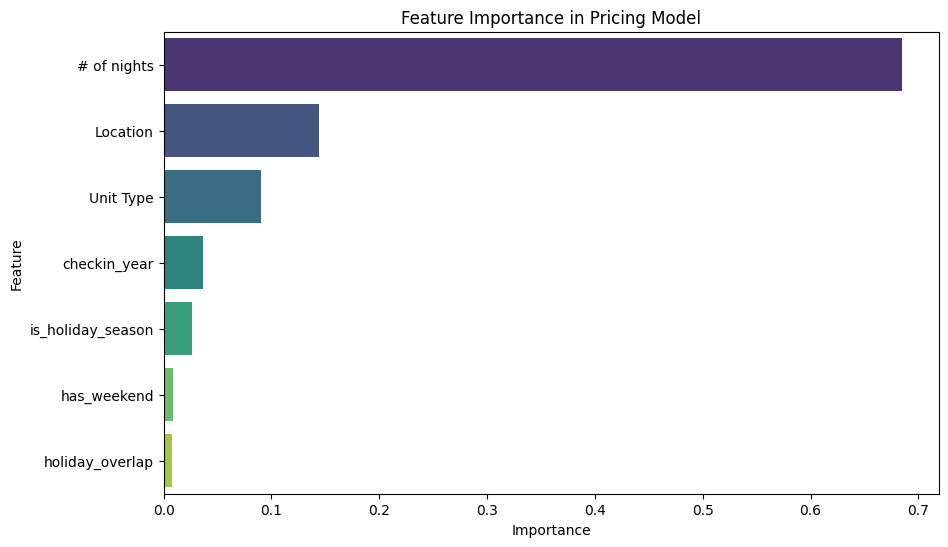

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_model_forest.feature_importances_
feature_names = X_train.columns


feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title("Feature Importance in Pricing Model")
plt.show()

###Add checkin date (nearby)
###Add is supply high for current reservation ?


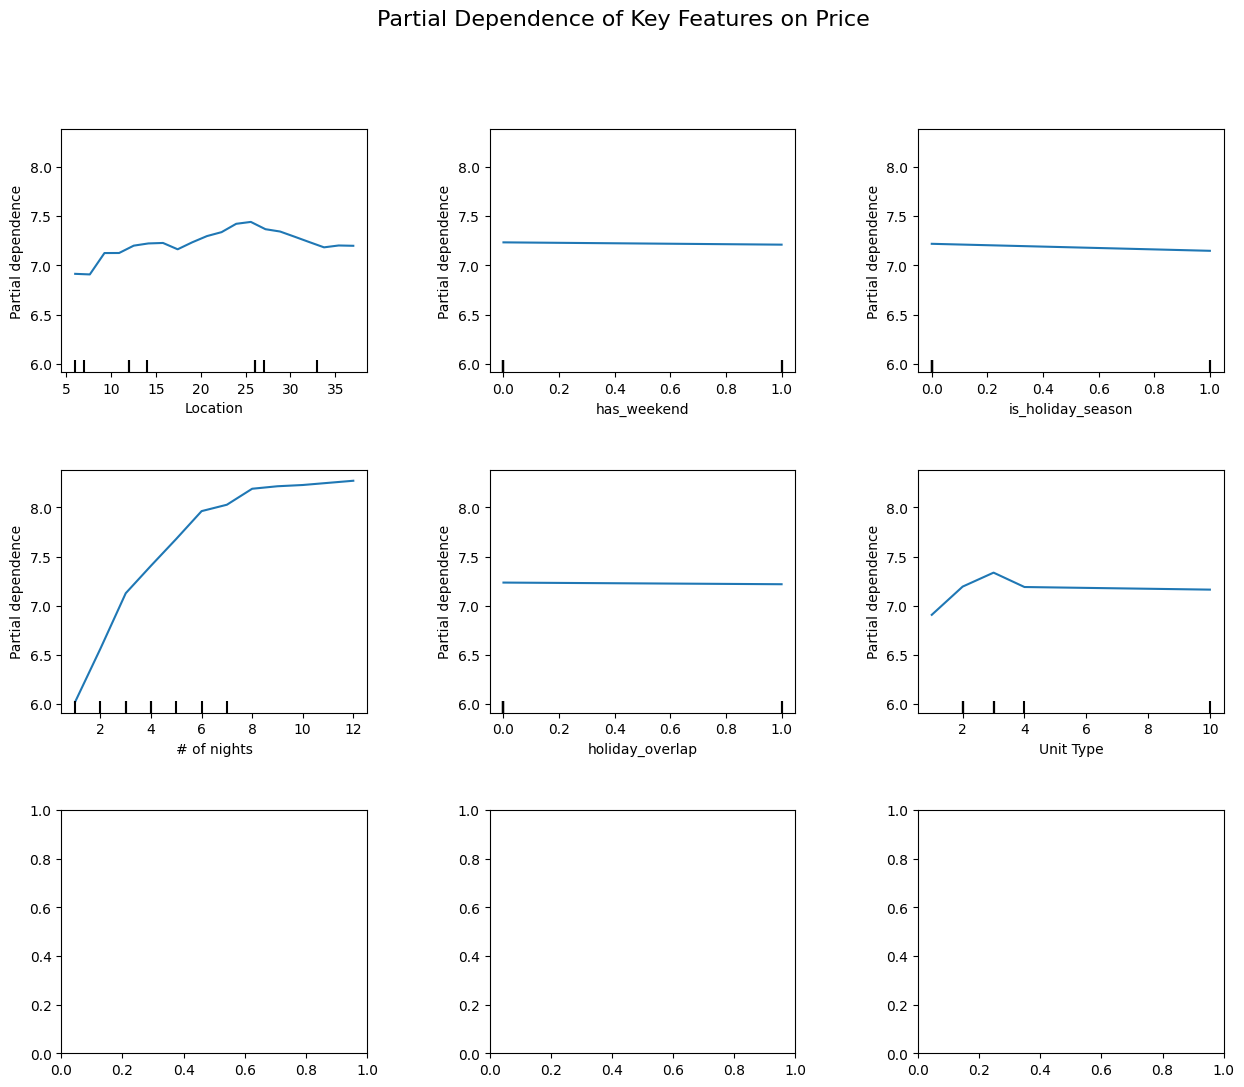

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

PartialDependenceDisplay.from_estimator(
    best_model_forest,
    X_train,
    features=['Location','has_weekend', 'is_holiday_season', '# of nights', 'holiday_overlap', 'Unit Type'],
    grid_resolution=20,
    n_jobs=-1,
    ax=ax.ravel()[:len(['Location','has_weekend', 'is_holiday_season', '# of nights', 'holiday_overlap', 'Unit Type'])]
)


plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("Partial Dependence of Key Features on Price", fontsize=16)
plt.show()


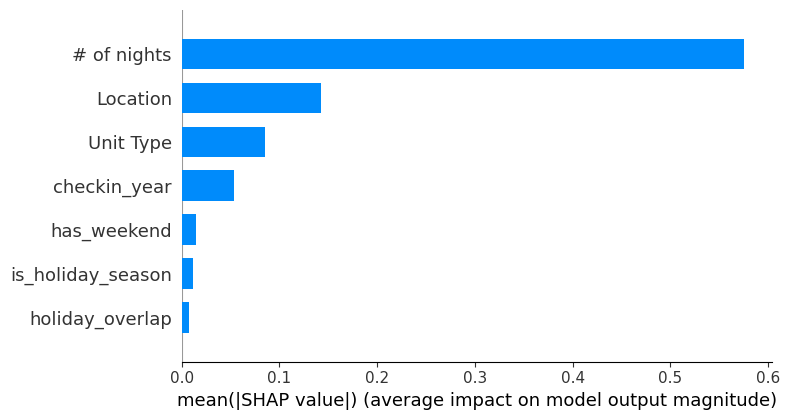

In [ ]:
import shap


explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
from sklearn.metrics import r2_score


r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

R² Score: 0.60
Mean Absolute Error (MAE): 537.21


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'


# Create a figure
fig = go.Figure()

# Add actual earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test.Earnings.values,
    mode='lines',
    name='Actual Earnings',
    line=dict(color='blue')
))

# Add predicted earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),
    y=y_pred,
    mode='lines',
    name='Predicted Earnings',
    line=dict(color='red', dash='dash')
))

# Customize layout
fig.update_layout(
    title='Actual vs. Predicted Earnings',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Earnings (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show the figure
fig.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


xgb = XGBRegressor(objective='reg:squarederror')


param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)


best_xgb = grid_search_xgb.best_estimator_


cv_scores_xgb = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R² (XGBoost):", np.mean(cv_scores_xgb))


log_predictions_xgb = best_xgb.predict(X_test)
original_scale_predictions_xgb = np.expm1(log_predictions_xgb)


mae_xgb = mean_absolute_error(y_test, original_scale_predictions_xgb)
r2_xgb = r2_score(y_test, original_scale_predictions_xgb)
print("Mean Absolute Error (MAE) (XGBoost):", mae_xgb)
print("R² Score (XGBoost):", r2_xgb)


Cross-validated R² (XGBoost): 0.8012115478515625
Mean Absolute Error (MAE) (XGBoost): 572.2293245757601
R² Score (XGBoost): 0.5928508639335632


In [ ]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, max_depth=5))
]

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

# Voting Regressor (weighted ensemble)
voting_regressor = VotingRegressor(
    estimators=base_models,
    weights=[0.5, 0.3, 0.2]  # Adjust weights based on model performance
)

# Evaluate stacking model
stacking_scores = cross_val_score(stacking_regressor, X_train, y_train, scoring='r2', cv=5)
print("Stacking Model R² Score:", stacking_scores.mean())

# Evaluate voting model
voting_scores = cross_val_score(voting_regressor, X_train, y_train, scoring='r2', cv=5)
print("Voting Model R² Score:", voting_scores.mean())


Stacking Model R² Score: 0.7581187236004225
Voting Model R² Score: 0.7534855313388501


In [ ]:
StackModel = voting_regressor.fit(X_train, y_train)

In [ ]:
y_pred = StackModel.predict(X_test)
y_pred = np.expm1(y_pred)
y_test = (y_test)
mae = mean_absolute_error(y_test, y_pred)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

R² Score: 0.68
Mean Absolute Error (MAE): 507.09


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'


# Create a figure
fig = go.Figure()

# Add actual earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test.Earnings.values,
    mode='lines',
    name='Actual Earnings',
    line=dict(color='blue')
))

# Add predicted earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(predictions))),
    y=y_pred,
    mode='lines',
    name='Predicted Earnings',
    line=dict(color='red', dash='dash')
))

# Customize layout
fig.update_layout(
    title='Actual vs. Predicted Earnings',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Earnings (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show the figure
fig.show()


In [ ]:
features = training_set[['Location', 'has_weekend', 'is_holiday_season', '# of nights', 'holiday_overlap', 'Unit Type', 'checkin_year']]
target = pd.DataFrame()
target['Earnings'] = training_set['Earnings']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    return model


input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


#early_stopping = EarlyStopping(
#    monitor="val_loss",  # Monitor validation loss
#    patience=100,         # Stop after 10 epochs of no improvement
#    restore_best_weights=True,  # Restore the best weights
#    verbose=1
#)
#
#reduce_lr = ReduceLROnPlateau(
#    monitor="val_loss",  # Monitor validation loss
#    factor=0.5,          # Reduce learning rate by half
#    patience=100,          # Wait 5 epochs before reducing LR
#    min_lr=1e-6,         # Minimum learning rate
#    verbose=1
#)

model_checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Software_Tools/Pricing_Tool/models/Pricing_DNN.keras",  # Save path for the best model
    monitor="val_mean_absolute_error",        # Monitor validation loss
    save_best_only=True,       # Save only the best model
    verbose=1
)


history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=200, batch_size=32,
                    callbacks=[model_checkpoint], verbose=1)


predictions = model.predict(X_test_scaled)

predictions = predictions.flatten()
y_test_original = y_test

mae = mean_absolute_error(y_test_original, predictions)
r2 = r2_score(y_test_original, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Epoch 1/200
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6503219.5000 - mean_absolute_error: 1894.4049
Epoch 1: val_mean_absolute_error improved from inf to 1846.48730, saving model to /content/drive/MyDrive/Software_Tools/Pricing_Tool/models/Pricing_DNN.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6518300.5000 - mean_absolute_error: 1892.1786 - val_loss: 6301543.5000 - val_mean_absolute_error: 1846.4873
Epoch 2/200
25/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6052195.0000 - mean_absolute_error: 1816.3005
Epoch 2: val_mean_absolute_error improved from 1846.48730 to 1845.57849, saving model to /content/drive/MyDrive/Software_Tools/Pricing_Tool/models/Pricing_DNN.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6393533.5000 - mean_absolute_error: 1834.8326 - val_loss: 6295964.5000 - val_mean_absolute_error: 1845.5785
Epoch 3/200
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6446897.0000 - mean_absolute_error: 1817.8777
Epoch 3: val_mean_absolute_error improved from 1845

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'


# Create a figure
fig = go.Figure()

# Add actual earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test.Earnings.values,
    mode='lines',
    name='Actual Earnings',
    line=dict(color='blue')
))

# Add predicted earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(predictions))),
    y=predictions,
    mode='lines',
    name='Predicted Earnings',
    line=dict(color='red', dash='dash')
))

# Customize layout
fig.update_layout(
    title='Actual vs. Predicted Earnings',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Earnings (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show the figure
fig.show()
